<a href="https://colab.research.google.com/github/varun-bhaseen/Reinforcement-Learning/blob/master/Single_Stock_trading_using_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Stock Trading Reinforcement Learning Project
Class Professor: Dr. Jahan Ghofraniha
Subject: CMPE 297 sec 47 Reinforcement Learning

Project Team:

| Team Member Name       | RL Algorithm Ownership     |
| :------------- | -----------: |
| Gulnara Timokhina | Actor-Critic and Advantage Actor-Critic (A2C)    |
| Mirsaeid Abolghasemi   |  Deep Q Network (DQN) |
| Poornapragna Vadiraj | Trust Region Policy Optimization (TRPO)|
|Varun Bhaseen | Proximal Policy Optimization (PPO)|


## 1.Introduction


###1.1. Purpose
The Primary Purpose of this project is to develop a set of models which can take decision over the trading of a single Stock on whether to Buy , Sell or Hold the stock by maximizing the assets given at hand

###1.2. Scope

Following is the scope of the Project:


1.   Environment: The environment is a trading environment created on top of default gym enviornment class. We are using the library stable-baselines to create a vertical stack of 3 different enviornments which are simulated by inheriting Gym Environment class.
2.   Actions: The actions which are provided in the environment is buying, selling or holding of stock (no-action)
3.   Observations: The observations received from the environment are in form of dataset features (close, high, low, open, volume) along with technical indicators like (macd, cci, dx, rsi) ['moving average convergence divergence', 'relative strength index', 'Commodity Channel Index', 'Directional Moving Index']

###1.3. Brief Description

In this project we have used a custom environment built on [Stockstats](https://github.com/jealous/stockstats) Library. The environment was prebuilt and has been used As-Is for single stock trading. Although the environment does enable multi stock tracking and trading feature it takes a lot of time for the agent to learn and hence for starters we are using a single stock as a protype.

All the details of baseline Colab and code can be checked in [References Section](https://colab.research.google.com/drive/1GZXFoUo9xum715GVFbtSi4y9fgwNZiZ7#scrollTo=y6zGC_ZQXeoZ&line=1&uniqifier=1)

The training and learning data is taken from Yahoo Finance. Yahoo Finance provides a API rom which we can download the latest stock data for any company from any Stock index like Nasdaq, Dow Jones Industrial, S&P and so on.

The data from Yahoo Finance comes with multiple features (Like volume, high, low, cut-off, ticker, turbulence etc.). Having greater number of features provides higher flexibility with agent to learn. 

But we will restrict the agent learning to following few features: 

* Date
* Open
* High
* Low
* Close
* Volume
* Ticker


In the below section we will see the description for each class for enviornment, feature engineering, data downloader, agent and performance.

In [1]:
# Installing the essential Libraries required for the project

!pip install yfinance # Yahoo finance library, provides hooks and api access
!pip install pandas # The downloaded data will be part of pandas dataframe
!pip install matplotlib # For visulaization
!pip install stockstats # Used to create Enviornment in gym for stock trading
!pip install gym # Primary hosted enviornment
!pip install stable-baselines[mpi] # Predefined RL Algorithms library
!pip install tensorflow==1.15.4 # Stockstats and stable-baselines work in TF-1.15
!pip install git+https://github.com/quantopian/pyfolio # For Visualization on test results

     |████████████████████████████████| 5.5MB 11.3MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=02f79ee3b876070a0be8860c2f2d407f4142c456f15470aa1f57656cdfacac66
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 245kB 8.6MB/s 
     |████████████████████████████████| 1.4MB 24.3MB/s 
  Created wheel for mpi4py: filename=mpi4py-3.0.3-cp36-cp36m-linux_x86_64.whl size=2074483 sha256=4ce0747ec7f5a33b1f152df0cb28324e5cf157ee5cf0bdbfd288d773c433af2e
  Stored in directory: /root/.cache/pip/wheels/18/e0/86/2b713dd512199096012ceca61429e12b960888de59818871d6
Successfully built mpi4py
     |████████████████████████████████| 110.5MB 37kB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |██████████████

##2.Importing Essential Packages and Configuring Default params


###2.1. Importing base Packages

Apart from base Libraries there are few class specific Libraries which are imported in the same cell in which we have made the respective classes using the libraries so that it is easy to understand the code

In [2]:
# Data Strcuture Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')

# Performance Libraries
import datetime

# Path and Directory management Libraries
import pathlib
import os

#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

# import yfinance as yf
#import finrl

# Setting up gym environment for baseline
from gym.utils import seeding
import gym
from gym import spaces

### 2.2. Configuring Base Values 

In [3]:
# ~~~~~~~~~~~~~~ TO BE DELETED ~~~~~~~~~~~~~~~~~~~~~~~
#pd.options.display.max_rows = 10
#pd.options.display.max_columns = 10


#PACKAGE_ROOT = pathlib.Path(finrl.__file__).resolve().parent
#PACKAGE_ROOT = pathlib.Path().resolve().parent

#TRAINED_MODEL_DIR = PACKAGE_ROOT / "trained_models"
#DATASET_DIR = PACKAGE_ROOT / "data"

# data
#now = datetime.datetime.now()
#TRAINED_MODEL_DIR = f"trained_models/{now}"
#os.makedirs(TRAINED_MODEL_DIR)

## check https://pypi.org/project/stockstats/ for different names


TRAINING_DATA_FILE = "data/ETF_SPY_2009_2020.csv"
TURBULENCE_DATA = "data/dow30_turbulence_index.csv"
TESTING_DATA_FILE = "test.csv"

DATA_SAVE_DIR = f"datasets"
TRAINED_MODEL_DIR = f"trained_models"
RESULTS_DIR = f"results"


## time_fmt = '%Y-%m-%d'
START_DATE = "2009-01-01"
END_DATE = "2020-09-30"

START_TRADE_DATE = "2019-01-01"

## dataset default columns
DEFAULT_DATA_COLUMNS = ['date','tic','close']

## stockstats technical indicator column names
TECHNICAL_INDICATORS_LIST = ['macd', 'rsi_30', 'cci_30', 'dx_30']


## Default Model Parameters for A2C, PPO, TRPO, TD3, DDPG

A2C_PARAMS = {'n_steps':5, 
			  'ent_coef':0.01, 
			  'learning_rate':0.0007,
			  'verbose':0,
			  'timesteps':20000}
PPO_PARAMS = {'n_steps':128, 
			  'ent_coef':0.01, 
			  'learning_rate':0.00025,   
			  'nminibatches':4,
			  'verbose':0,
			  'timesteps':20000}
DDPG_PARAMS = {'batch_size':128, 
			   'buffer_size':50000,
			   'verbose':0,
			   'timesteps':20000}
TD3_PARAMS = {'batch_size':128, 
			   'buffer_size':50000,
			   'learning_rate':1e-4,
			   'verbose':0,
			   'timesteps':20000}

#Stock to be traded

SINGLE_TICKER =['AAPL']

##3.Yahoo Data Downloader

Here we have a Yahoo downloader, to collect data from Yahoo API. The values used for initializing is start date, end date and Ticker list

we have two methods:

1. Fetch Data: This is used to fetch data from the API and returns a Pandas Dataframe with seven columns for the specified stock ticker: 


```
* date, 
* open, 
* high, 
* low, 
* close, 
* volume and 
* tick symbol
```

2. Select Equal Rows Stock: This method takes in the dataframe and resets the index. This is done after feature engineering mostly to drop any na or null values. The method returns a dataframe with equal number of rows for given stock ticker list


In [4]:
import yfinance as yf

class YahooDownloader:
    """Provides methods for retrieving daily stock data from
    Yahoo Finance API
    Attributes
    ----------
        start_date : str
            start date of the data 
        end_date : str
            end date of the data 
        ticker_list : list
            a list of stock tickers 
    """
    def __init__(self, 
        start_date:str,
        end_date:str,
        ticker_list:list):

        self.start_date = start_date
        self.end_date = end_date
        self.ticker_list = ticker_list


    def fetch_data(self) -> pd.DataFrame:

        # Download and save the data in a pandas DataFrame:
        data_df = pd.DataFrame()
        for tic in self.ticker_list:
            temp_df = yf.download(tic, start=self.start_date, end=self.end_date)
            temp_df['tic'] = tic
            data_df=data_df.append(temp_df)
        # reset the index, we want to use numbers as index instead of dates
        data_df=data_df.reset_index()
        try:
            # convert the column names to standardized names
            data_df.columns = ['date','open','high','low','close','adjcp','volume','tic']
            # use adjusted close price instead of close price
            data_df['close'] = data_df['adjcp']
            # drop the adjusted close price column
            data_df = data_df.drop('adjcp', 1)
        except NotImplementedError:
            print("the features are not supported currently")

        # convert date to standard string format, easy to filter
        data_df['date']=data_df.date.apply(lambda x: x.strftime('%Y-%m-%d'))
        # drop missing data 
        data_df = data_df.dropna()
        data_df = data_df.reset_index(drop=True)
        print("Shape of DataFrame: ", data_df.shape)
        #print("Display DataFrame: ", data_df.head())

        return data_df

## 4.Feature Engineering and Preprocess Data

This class has features for preprocessing the data for stock price that we have downloaded from Yahoo Finance library. The preprocessing is required so that we can standardzie the data from different stock indexes (like S&P, DJI or Nasdaq) and also remove any `na` or `null` values from the dataset. We can remove and drop such rows and have a uniform data.

The key methods of this class are: 

* `Preprocess Data`: Fills the missing values at beginning and at end. Checks if any additional indicators are missing and needs to be added from stockstats library. Also checks if turbulance is True or not and If true then add turbulunce value.

* `_add_technical_indicator`: Add the following technical indicators from stockstats library ['macd', 'rsi_30', 'cci_30', 'dx_30'] for the given stock. These stand as 'moving average convergence divergence', 'relative strength index', 'Commodity Channel Index', 'Directional Moving Index'. These values are very important for RL Agent to learn and understand the actions that needs to be taken on stock based on strength indicators.

* `_add_turbulence`: Calculate turbulence from the `_calculate_turbulence` method. Then add the turbulence for the respective stock. Turbulence in the stock market means volatility. Higher Volatality means frightened investor and higher selling for the stock. Whereas lower volatality means calm investor and holding of stock.

* `_Calculate_turbulence`: Here the turbulence index is calculated based on VIX from Dow Jones Industrial Average. This value will help to decide the volatality of a particular stock in market and enable RL with additional information of Buying or selling of stock.

* `get_type_list`: This method checks what type of features are available in the data set. That is downloaded from Yahoo Finance.
    * If number of Features is 1 then they are only the  ["close"] value of stock
    * Feature = 2: ["close", "high"]
    * Feature = 3: ["close", "high", "low"]
    * Feature = 4: ["close", "high", "low", "open"]
    * Feature = 5: ["close", "high", "low", "open","volume"] 

In [5]:
# import numpy as np
# import pandas as pd
from stockstats import StockDataFrame as Sdf


class FeatureEngineer:
    """Provides methods for preprocessing the stock price data
    Attributes
    ----------
        df: DataFrame
            data downloaded from Yahoo API
        feature_number : int
            number of features we used
        use_technical_indicator : boolean
            we technical indicator or not
        use_turbulence : boolean
            use turbulence index or not
    """
    def __init__(self, 
        df,
        feature_number = 5,
        use_technical_indicator=True,
        use_turbulence=False):

        self.df = df
        self.feature_number = feature_number
        
        # From the _get_type_list method fetch all features that needs to be 
        # added to the dataset
        
        type_list = self.__get_type_list(feature_number)
        
        self.__features = type_list

        # Default data columns that we want to have in our dataset is 
        # ['date','tic','close'] along with features from method `get_type_list`

        self.__data_columns = DEFAULT_DATA_COLUMNS + self.__features
        
        self.use_technical_indicator = use_technical_indicator

        # The technical Indicator list is defined initially. The values from this
        # list are taken from stockstats and passed a pd dataframe. Refer the 
        # below link : https://pypi.org/project/stockstats/

        self.tech_indicator_list = TECHNICAL_INDICATORS_LIST
        self.use_turbulence=use_turbulence


    def preprocess_data(self):
        """main method to do the feature engineering
        @:param config: source dataframe
        @:return: a DataMatrices object
        """
        df = self.df.copy()

        # add technical indicators
        # stockstats require all 5 columns
        if (self.use_technical_indicator==True) & (self.feature_number>=5):
            # add technical indicators using stockstats
            df=self.__add_technical_indicator(df)
            print("Successfully added technical indicators")

        # add turbulence index for multiple stock
        if self.use_turbulence==True:
            df = self.__add_turbulence(df)
            print("Successfully added turbulence index")

       
        # fill the missing values at the beginning and the end
        df=df.fillna(method='bfill').fillna(method="ffill")
        return df


    def __add_technical_indicator(self, data):
            """
            calculate technical indicators
            use stockstats package to add technical inidactors
            :param data: (df) pandas dataframe
            :return: (df) pandas dataframe
            """
            df = data.copy()
            stock = Sdf.retype(df.copy())
            unique_ticker = stock.tic.unique()

            for indicator in self.tech_indicator_list:
                indicator_df = pd.DataFrame()
                for i in range(len(unique_ticker)):
                    try:
                        temp_indicator = stock[stock.tic == unique_ticker[i]][indicator]
                        temp_indicator= pd.DataFrame(temp_indicator)
                        indicator_df = indicator_df.append(temp_indicator, ignore_index=True)
                    except Exception as e:
                        print(e)
                df[indicator] = indicator_df
            return df



    def __add_turbulence(self, data):
        """
        add turbulence index from a precalcualted dataframe
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        turbulence_index = self.__calcualte_turbulence(df)
        df = df.merge(turbulence_index, on='date')
        df = df.sort_values(['date','tic']).reset_index(drop=True)
        return df

    def __get_type_list(self, feature_number):
        """
        :param feature_number: an int indicates the number of features
        :return: a list of features n
        """
        if feature_number == 1:
            type_list = ["close"]
        elif feature_number == 2:
            type_list = ["close", "volume"]
            #raise NotImplementedError("the feature volume is not supported currently")
        elif feature_number == 3:
            type_list = ["close", "high", "low"]
        elif feature_number == 4:
            type_list = ["close", "high", "low", "open"]
        elif feature_number == 5:
            type_list = ["close", "high", "low", "open","volume"]  
        else:
            raise ValueError("feature number could not be %s" % feature_number)
        return type_list


    def __calcualte_turbulence(self, data):
        """calculate turbulence index based on dow 30"""
        # can add other market assets
        df = data.copy()
        df_price_pivot=df.pivot(index='date', columns='tic', values='close')
        unique_date = df.date.unique()
        # start after a year
        start = 252
        turbulence_index = [0]*start
        #turbulence_index = [0]
        count=0
        for i in range(start,len(unique_date)):
            current_price = df_price_pivot[df_price_pivot.index == unique_date[i]]
            hist_price = df_price_pivot[[n in unique_date[0:i] for n in df_price_pivot.index ]]
            cov_temp = hist_price.cov()
            current_temp=(current_price - np.mean(hist_price,axis=0))
            temp = current_temp.values.dot(np.linalg.inv(cov_temp)).dot(current_temp.values.T)
            if temp>0:
                count+=1
                if count>2:
                    turbulence_temp = temp[0][0]
                else:
                    #avoid large outlier because of the calculation
                    # Just begin at zero
                    turbulence_temp=0
            else:
                turbulence_temp=0
            turbulence_index.append(turbulence_temp)
        
        
        turbulence_index = pd.DataFrame({'date':df_price_pivot.index,
                                         'turbulence':turbulence_index})
        return turbulence_index

##5.Data Split

So far we have carried out following activities: 

1.   Created Class to download the data from Yahoo Finance API
2.   Preprocess the Data to have the desired fields that we want

Now we will create a class which will help us to split the entire preprocessed data into Training and Testing data



In [7]:
from __future__ import division,absolute_import,print_function
# import numpy as np
# import pandas as pd


def load_dataset(*, file_name: str) -> pd.DataFrame:
    """
    load csv dataset from path
    """
    #_data = pd.read_csv(f"{config.DATASET_DIR}/{file_name}")
    _data = pd.read_csv(file_name)
    return _data

def data_split(df,start,end):
    """
    split the dataset into training or testing using date
    """
    data = df[(df.date >= start) & (df.date < end)]
    data=data.sort_values(['date','tic'],ignore_index=True)
    data.index = data.date.factorize()[0]
    return data


def convert_to_datetime(time):
  """
  Creating a date time object for any given time from string
  """
  time_fmt = '%Y-%m-%dT%H:%M:%S'
  if isinstance(time, str):
    
    return datetime.datetime.strptime(time, time_fmt)

##6.Environment Setup

The environment that we have for our model is actually the trading environment itself. To create the environment we are doing following steps:



###6.1. Environment Setup
First is using Stable-Baselines library to call DummyVecEnv. The reason for that is because Vectorized Environments are a method for stacking multiple independent environments into a single environment, This will help us to create a stacked environment. This environment will be called later to create the trading environment for the RL Agent to work on. We are creating Three environments stacked together. :

* Training Environment
* Testing or Validation Envrionment
* Trading Environment

In [8]:
from stable_baselines.common.vec_env import DummyVecEnv



class EnvSetup:
    """Provides methods for retrieving daily stock data from
    Yahoo Finance API
    Attributes
    ----------
        df
        feature_number : str
            start date of the data (modified from config.py)
        use_technical_indicator : str
            end date of the data (modified from config.py)
        use_turbulence : list
            a list of stock tickers (modified from config.py)
    """
    def __init__(self, 
        stock_dim:int,
        hmax = 100,
        initial_amount = 1000000,
        transaction_cost_pct = 0.001,
        reward_scaling = 1e-4):

        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.tech_indicator_list = TECHNICAL_INDICATORS_LIST
        # account balance + close price + shares + technical indicators
        self.state_space = 1 + 2*self.stock_dim + len(self.tech_indicator_list)*self.stock_dim
        self.action_space = self.stock_dim


    def create_env_training(self, data, env_class, turbulence_threshold=150):
        env_train = DummyVecEnv([lambda: env_class(df = data,
                                                    stock_dim = self.stock_dim,
                                                    hmax = self.hmax,
                                                    initial_amount = self.initial_amount,
                                                    transaction_cost_pct = self.transaction_cost_pct,
                                                    reward_scaling = self.reward_scaling,
                                                    state_space = self.state_space,
                                                    action_space = self.action_space,
                                                    tech_indicator_list = self.tech_indicator_list,
                                                    turbulence_threshold = turbulence_threshold)])
        return env_train


    def create_env_validation(self, data, env_class, turbulence_threshold=150):
        env_validation = DummyVecEnv([lambda: env_class(df = data,
                                            stock_dim = self.stock_dim,
                                            hmax = self.hmax,
                                            initial_amount = self.initial_amount,
                                            transaction_cost_pct = self.transaction_cost_pct,
                                            reward_scaling = self.reward_scaling,
                                            state_space = self.state_space,
                                            action_space = self.action_space,
                                            tech_indicator_list = self.tech_indicator_list,
                                            turbulence_threshold = turbulence_threshold)])
        obs_validation = env_validation.reset()


        return env_validation, obs_validation

    def create_env_trading(self, env_class, data, turbulence_threshold=150):
        env_trade = DummyVecEnv([lambda: env_class(df = data,
                                            stock_dim = self.stock_dim,
                                            hmax = self.hmax,
                                            initial_amount = self.initial_amount,
                                            transaction_cost_pct = self.transaction_cost_pct,
                                            reward_scaling = self.reward_scaling,
                                            state_space = self.state_space,
                                            action_space = self.action_space,
                                            tech_indicator_list = self.tech_indicator_list,
                                            turbulence_threshold = turbulence_threshold)])
        obs_trade = env_trade.reset()


        return env_trade, obs_trade


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



###6.2. Simulation Environment

This is the environment in which the RL agent will execute the trading actions. The environment is created on top of Open AI Gym. The Gym provides and Environment class (`Env`) which can be used to inherit all the environment sub classes like: 

* The Action space: Here the action space is Stock dimentions or number of eatures present in the dataset. 

* The Observation space: Observations are pieces of information that enviornment gives the agent on every timestamp besides the reward. Here the environment is provided the agent a set of numbers from 0 to numpy infinity and shape is from state space.

* The State space: The state space is defined in dummy class and is an integer of shape defined by stock dimension which in our case is a tensor of shape 8

* State: The states in our environment are the features from technical indicator list defined during class preprocessing (macd, rsi, cci, dx)


The environment can do following actions:

* Sell Stock: defined in method `_sell_stock`. 
* Buy Stock: defined in method `_buy_stock`.

The Environment decides on action based on input received in each step:

* Execute step: defined in method `step`. Each step will return a reward, state and terminal. Steps are important because it tells the program to terminate of agent doesn't converge after fixed steps. Currently we have a max step of 100 set as default. This can be changed by changing hmax value in dummy env class stated above during initialization.

The Default parameters of the environment taken from Gym Enviornment class:

* Reset: Defined in method `reset`. Taken directly from gym class to reset the environment to initial state after each episode or step
* Seed: random seeding
* Render: rendering mode is Human
* save asset memory: Save datelist, asset list in Account value. It returns account value. A default asset of $100000 ($100K) is given to agent for maximising the returns by selling and buying of stocks


In [9]:
from gym.utils import seeding
import gym
from gym import spaces

class SingleStockEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = -1, high = 1,shape = (self.action_space,)) 
        # Shape = 181: [Current Balance]+[prices 1-30]+[owned shares 1-30] 
        # +[macd 1-30]+ [rsi 1-30] + [cci 1-30] + [adx 1-30]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (self.state_space,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state
        self.state = [self.initial_amount] + \
                      [self.data.close] + \
                      [0]*self.stock_dim  + \
                      sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])
        # initialize reward
        self.reward = 0
        self.cost = 0
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory=[]
        self.date_memory=[self.data.date]
        self.trades = 0
        #self.reset()
        self._seed()


    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.state[index+self.stock_dim+1] > 0:
            #update balance
            self.state[0] += \
            self.state[index+1]*min(abs(action),self.state[index+self.stock_dim+1]) * \
             (1- self.transaction_cost_pct)

            self.state[index+self.stock_dim+1] -= min(abs(action), self.state[index+self.stock_dim+1])
            self.cost +=self.state[index+1]*min(abs(action),self.state[index+self.stock_dim+1]) * \
             self.transaction_cost_pct
            self.trades+=1
        else:
            pass

    
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        available_amount = self.state[0] // self.state[index+1]
        # print('available_amount:{}'.format(available_amount))

        #update balance
        self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                          (1+ self.transaction_cost_pct)

        self.state[index+self.stock_dim+1] += min(available_amount, action)

        self.cost+=self.state[index+1]*min(available_amount, action)* \
                          self.transaction_cost_pct
        self.trades+=1
        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            #plt.plot(self.asset_memory,'r')
            #plt.savefig('results/account_value_train.png')
            #plt.close()
            end_total_asset = self.state[0]+ \
                sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))

            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(end_total_asset))
            df_total_value = pd.DataFrame(self.asset_memory)
            #df_total_value.to_csv('results/account_value_train.csv')
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))- self.initial_amount ))
            print("total_cost: ", self.cost)
            print("total_trades: ", self.trades)
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            if df_total_value['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                    df_total_value['daily_return'].std()
              print("Sharpe: ",sharpe)
              print("=================================")
            df_rewards = pd.DataFrame(self.rewards_memory)
            #df_rewards.to_csv('results/account_rewards_train.csv')
            
            # print('total asset: {}'.format(self.state[0]+ sum(np.array(self.state[1:29])*np.array(self.state[29:]))))
            #with open('obs.pkl', 'wb') as f:  
            #    pickle.dump(self.state, f)
            
            return self.state, self.reward, self.terminal,{}

        else:
            # print(np.array(self.state[1:29]))
            self.date_memory.append(self.data.date)
            self.actions_memory.append(actions)

            actions = actions * self.hmax
            #actions = (actions.astype(int))
            
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            #print("begin_total_asset:{}".format(begin_total_asset))
            
            argsort_actions = np.argsort(actions)
            
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])

            self.day += 1
            self.data = self.df.loc[self.day,:]         
            #load next state
            # print("stock_shares:{}".format(self.state[29:]))
            self.state =  [self.state[0]] + \
                    [self.data.close] + \
                    list(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]) + \
                      sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            self.asset_memory.append(end_total_asset)
            #print("end_total_asset:{}".format(end_total_asset))
            
            self.reward = end_total_asset - begin_total_asset            
            # print("step_reward:{}".format(self.reward))
            self.rewards_memory.append(self.reward)
            
            self.reward = self.reward*self.reward_scaling



        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        self.rewards_memory = []
        self.actions_memory=[]
        self.date_memory=[self.data.date]
        #initiate state
        self.state = [self.initial_amount] + \
                      [self.data.close] + \
                      [0]*self.stock_dim + \
                      sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])
        # iteration += 1 
        return self.state
    
    def render(self, mode='human'):
        return self.state
    
    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'account_value':asset_list})
        return df_account_value

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

##7.Model Definition

Here we are defining the RL models that will be run on the Stock Trading environment that has been defined earlier. The models are not created from scratch and rather used as a prebuilt models from Stable-baselines.The model classes are imported from the library and only the parameters needs to be defined like Number of steps, enviornment, gamma, entropy coefficients, ;earning rate, alpha, epsilon etc.

Following are the models that has been taken:

* DQN: Deep Q Network
* A2C: Advantage Actor Critic
* TRPO: Trust Region Policy Optimization
* PPO: Proximal Policy Optimization

In [12]:
import time
import gym

from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv

class RLAgent:
    """Provides implementations for DRL algorithms
    Attributes
    ----------
        env: gym environment class
            user-defined class
    Methods
    -------
    train_PPO()
        the implementation for PPO algorithm
    train_A2C()
        the implementation for A2C algorithm
    train_DDPG()
        the implementation for DDPG algorithm
     train_TD3()
        the implementation for TD3 algorithm       
    """
    def __init__(self, env):
        self.env = env

    def train_A2C(self, model_name, model_params = A2C_PARAMS):
        """A2C model"""
        from stable_baselines import A2C
        env_train = self.env
        start = time.time()
        model = A2C('MlpPolicy', env_train, 
                    n_steps = model_params['n_steps'],
                    ent_coef = model_params['ent_coef'],
                    learning_rate = model_params['learning_rate'],
                    verbose = model_params['verbose']
                    )
        model.learn(total_timesteps=model_params['timesteps'])
        end = time.time()

        model.save(f"{TRAINED_MODEL_DIR}/{model_name}")
        print('Training time (A2C): ', (end-start)/60,' minutes')
        return model


    def train_DDPG(self, model_name, model_params = DDPG_PARAMS):
        """DDPG model"""
        from stable_baselines import DDPG
        from stable_baselines.ddpg.policies import DDPGPolicy
        from stable_baselines.common.noise import OrnsteinUhlenbeckActionNoise


        env_train = self.env

        n_actions = env_train.action_space.shape[-1]
        param_noise = None
        action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5)*np.ones(n_actions))

        start = time.time()
        model = DDPG('MlpPolicy', 
                    env_train,
                    batch_size=model_params['batch_size'],
                    buffer_size=model_params['buffer_size'],
                    param_noise=param_noise,
                    action_noise=action_noise,
                    verbose=model_params['verbose']
                    )
        model.learn(total_timesteps=model_params['timesteps'])
        end = time.time()

        model.save(f"{TRAINED_MODEL_DIR}/{model_name}")
        print('Training time (DDPG): ', (end-start)/60,' minutes')
        return model


    def train_TD3(self, model_name, model_params = TD3_PARAMS):
        """TD3 model"""
        from stable_baselines import TD3
        from stable_baselines.common.noise import NormalActionNoise

        env_train = self.env

        n_actions = env_train.action_space.shape[-1]
        action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1*np.ones(n_actions))

        start = time.time()
        model = TD3('MlpPolicy', env_train,
                    batch_size=model_params['batch_size'],
                    buffer_size=model_params['buffer_size'],
                    learning_rate = model_params['learning_rate'],
                    action_noise = action_noise,
                    verbose=model_params['verbose']
                    )
        model.learn(total_timesteps=model_params['timesteps'])
        end = time.time()

        model.save(f"{TRAINED_MODEL_DIR}/{model_name}")
        print('Training time (DDPG): ', (end-start)/60,' minutes')
        return model


    def train_PPO(self, model_name, model_params = PPO_PARAMS):
        """PPO model"""
        from stable_baselines import PPO2
        env_train = self.env

        start = time.time()
        model = PPO2('MlpPolicy', env_train,
                     n_steps = model_params['n_steps'],
                     ent_coef = model_params['ent_coef'],
                     learning_rate = model_params['learning_rate'],
                     nminibatches = model_params['nminibatches'],
                     verbose = model_params['verbose']
                     )
        model.learn(total_timesteps=model_params['timesteps'])
        end = time.time()

        model.save(f"{TRAINED_MODEL_DIR}/{model_name}")
        print('Training time (PPO): ', (end-start)/60,' minutes')
        return model

    @staticmethod
    def RL_prediction(model, test_data, test_env, test_obs):
        """make a prediction"""
        start = time.time()
        account_memory = []
        for i in range(len(test_data.index.unique())):
            action, _states = model.predict(test_obs)
            test_obs, rewards, dones, info = test_env.step(action)
            if i == (len(test_data.index.unique()) - 2):
                account_memory = test_env.env_method(method_name = 'save_asset_memory')
        end = time.time()
        return account_memory[0]

##8.Performance Evaluation

The performance of the models will be visualized using the libraries Pyfolio and Matplot library. WE are using Following standard metrics to check the comparision of the models:

* Daily return: defined in method `backtest_strat`
* Percent change in closing from previous day: defined in method `baseline_strat`
* Annual return and Sharpe ratio: defined in method `get_daily_return`

In [13]:
# import pandas as pd
# import numpy as np

from pyfolio import timeseries 
import pyfolio
import matplotlib.pyplot as plt

# Backtest_strat defines the method to create daily returns for the given dataframe
# The return value is a timeseries data for 
def backtest_strat(df):
    strategy_ret= df.copy()
    strategy_ret['date'] = pd.to_datetime(strategy_ret['date'])
    strategy_ret.set_index('date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts


def baseline_strat(ticker, start, end):
    # Using the class Yahoo downloader to fetch the data for Dow Jones Industrial 
    # Average. 
    
    dji = YahooDownloader(start_date = start,
                     end_date = end,
                     ticker_list = [ticker]).fetch_data()
    # using pandas % change method to see the change in value on each closing day from previous day

    dji['daily_return']=dji['close'].pct_change(1) 
    
    dow_strat = backtest_strat(dji)
    return dji, dow_strat

# Using the below method to get daily return feature for the dataset. 
def get_daily_return(df):
    df['daily_return']=df.account_value.pct_change(1)
    #df=df.dropna()
    sharpe = (252**0.5)*df['daily_return'].mean()/ \
    df['daily_return'].std()
    
    annual_return = ((df['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)
    print("sharpe ratio: ", sharpe)    
    return df

def BackTestStats(account_value):
    df = account_value.copy()
    df=get_daily_return(df)
    DRL_strat = backtest_strat(df)
    perf_func = timeseries.perf_stats 
    perf_stats_all = perf_func( returns=DRL_strat, 
                                factor_returns=DRL_strat, 
                                 positions=None, transactions=None, turnover_denom="AGB")
    print(perf_stats_all)
    return perf_stats_all

def BaselineStats(baseline_ticker = '^DJI', 
                  baseline_start = START_TRADE_DATE, 
                  baseline_end = END_DATE):

    dji, dow_strat = baseline_strat(ticker = baseline_ticker, 
                                    start = baseline_start, 
                                    end = baseline_end)
    perf_func = timeseries.perf_stats 
    perf_stats_all = perf_func( returns=dow_strat, 
                                factor_returns=dow_strat, 
                                 positions=None, transactions=None, turnover_denom="AGB")
    print(perf_stats_all)
    return perf_stats_all

def BackTestPlot(account_value, 
                 baseline_start = START_TRADE_DATE, 
                 baseline_end = END_DATE, 
                 baseline_ticker = '^DJI'):

    df = account_value.copy()
    df = get_daily_return(df)

    dji, dow_strat = baseline_strat(ticker = baseline_ticker, 
                                    start = baseline_start, 
                                    end = baseline_end)
    df['date'] = dji['date']
    df=df.dropna()
    
    DRL_strat = backtest_strat(df)

    with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=dow_strat, set_context=False)

##9.Execution of RL Model


###9.1. Create Directories

Create respective directories to save the data downloaded from Yahoo Downloader

In [14]:
import os
if not os.path.exists("./" + DATA_SAVE_DIR):
    os.makedirs("./" + DATA_SAVE_DIR)
if not os.path.exists("./" + TRAINED_MODEL_DIR):
    os.makedirs("./" + TRAINED_MODEL_DIR)
if not os.path.exists("./" + RESULTS_DIR):
    os.makedirs("./" + RESULTS_DIR)

###9.2. DownLoad Data

Download the data from Yahoo Downloader class defined earlier for ***Apple*** stock

In [15]:
# Download and save the data in a pandas DataFrame:
data_df = YahooDownloader(start_date = START_DATE,
                          end_date = END_DATE,
                          ticker_list = ['AAPL']).fetch_data()

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2956, 7)


In [16]:
data_df.head()

,date,open,high,low,close,volume,tic
0,2009-01-02,3.067143,3.251429,3.041429,2.773207,746015200,AAPL
1,2009-01-05,3.327500,3.435000,3.311071,2.890248,1181608400,AAPL
2,2009-01-06,3.426786,3.470357,3.299643,2.842576,1289310400,AAPL
3,2009-01-07,3.278929,3.303571,3.223572,2.781153,753048800,AAPL
4,2009-01-08,3.229643,3.326786,3.215714,2.832797,673500800,AAPL


###9.3. Feature engineering

Adding additional features and technical indicators which will help the RL model to better observe the value of stocks and take decision on next action

In [17]:
data_df = FeatureEngineer(data_df,
                          feature_number=5,
                          use_technical_indicator=True,
                          use_turbulence=False).preprocess_data()

Successfully added technical indicators


In [18]:
data_df.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30
0,2009-01-02,3.067143,3.251429,3.041429,2.773207,746015200,AAPL,0.000000,100.000000,66.666667,100.000000
1,2009-01-05,3.327500,3.435000,3.311071,2.890248,1181608400,AAPL,0.002626,100.000000,66.666667,100.000000
2,2009-01-06,3.426786,3.470357,3.299643,2.842576,1289310400,AAPL,0.001868,70.355256,46.810872,100.000000
3,2009-01-07,3.278929,3.303571,3.223572,2.781153,753048800,AAPL,-0.000741,50.429273,-29.735567,43.608349
4,2009-01-08,3.229643,3.326786,3.215714,2.832797,673500800,AAPL,-0.000087,60.227005,-9.052599,48.358256


###9.4. Split Data

SPlitting the data into training and testing based on dates. Follwoing are the dates considered:

* Training: 2009-01-01 to 2018-12-31

* Trade: 2019-01-01 to 2020-09-30

In [19]:
train = data_split(data_df, start = START_DATE, end = START_TRADE_DATE)
trade = data_split(data_df, start = START_TRADE_DATE, end = END_DATE)

##10.Executing the RL agent on training environment

We will use training data and run our RL agents on the training environment and see how well they learn and perform.




###10.1. Initializing the Environment

In [20]:
env_setup = EnvSetup(stock_dim = len(train.tic.unique()),
                     hmax = 200,
                     initial_amount = 100000,
                     transaction_cost_pct = 0.001)

In [21]:
env_train = env_setup.create_env_training(data = train,
                                          env_class = SingleStockEnv)

In [22]:
# the stock dimension is 1, because we only use the price data of AAPL.
# len(train.tic.unique())
train.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30
0,2009-01-02,3.067143,3.251429,3.041429,2.773207,746015200,AAPL,0.000000,100.000000,66.666667,100.000000
1,2009-01-05,3.327500,3.435000,3.311071,2.890248,1181608400,AAPL,0.002626,100.000000,66.666667,100.000000
2,2009-01-06,3.426786,3.470357,3.299643,2.842576,1289310400,AAPL,0.001868,70.355256,46.810872,100.000000
3,2009-01-07,3.278929,3.303571,3.223572,2.781153,753048800,AAPL,-0.000741,50.429273,-29.735567,43.608349
4,2009-01-08,3.229643,3.326786,3.215714,2.832797,673500800,AAPL,-0.000087,60.227005,-9.052599,48.358256


###10.2. Run the RL agent

Running the Agent on the training environment

In [23]:
agent = RLAgent(env = env_train)

####10.2.1. Model 1: A2C

In [24]:
print("==============Model Training A2C===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
a2c_params_tuning = {'n_steps':5, 
			  'ent_coef':0.005, 
			  'learning_rate':0.0007,
			  'verbose':0,
			  'timesteps':100000}
model_a2c = agent.train_A2C(model_name = "A2C_{}".format(now), model_params = a2c_params_tuning)

==============Model Training A2C===========




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


begin_total_asset:100000
end_total_asset:208759.70286648074
total_reward:108759.70286648074
total_cost:  6205.7507758953725
total_trades:  2497
Sharpe:  0.7025740699168577
begin_total_asset:100000
end_total_asset:201000.45040346222
total_reward:101000.45040346222
total_cost:  6317.942821411949
total_trades:  2475
Sharpe:  0.6071676576428506
begin_total_asset:100000
end_total_asset:200473.39198354416
total_reward:100473.39198354416
total_cost:  4761.305816830019
total_trades:  2266
Sharpe:  0.5711002330961301
begin_total_asset:100000
end_total_asset:98954.04868116234
total_reward:-1045.95131883

####10.2.2. Model 2: DDPG

In [25]:
print("==============Model Training DDPG===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
ddpg_params_tuning = {
                     'batch_size': 128,
			               'buffer_size':100000, 
			               'verbose':0,
			               'timesteps':50000}
model_ddpg = agent.train_DDPG(model_name = "DDPG_{}".format(now), model_params = ddpg_params_tuning)

==============Model Training DDPG===========
Instructions for updating:
Use keras.layers.Dense instead.



begin_total_asset:100000
end_total_asset:377135.0107083919
total_reward:277135.0107083919
total_cost:  1534.5546497368925
total_trades:  2192
Sharpe:  0.854492585470872
begin_total_asset:100000
end_total_asset:1192800.2620222173
total_reward:1092800.2620222173
total_cost:  762.7631087194296
total_trades:  2515
Sharpe:  1.1363709257135883
begin_total_asset:100000
end_total_asset:1044771.42051308
total_reward:944771.42051308
total_cost:  638.4898091155976
total_trades:  2515
Sharpe:  1.0593063095352273
begin_total_asset:100000
end_total_asset:1033502.9832686754
total_reward:933502.9832686754
total_cost:  1031.6532132570592
total_trades:  2515
Sharpe:  1.0565558663416368
begin_total_asset:100000
end_total_asset:424367.1969857647
total_reward:324367.1969857647
total_cost:  1420.3697861331339
total_trades:  1401
Sharpe:  1.2031245673866544
begin_total_asset:100000
end_total_asset:10721

####10.2.3. Model 3: PPO

In [26]:
print("==============Model Training PPO===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
ppo_params_tuning = {'n_steps':128, 
                     'nminibatches': 4,
			               'ent_coef':0.005, 
			               'learning_rate':0.00025,
			              'verbose':0,
			              'timesteps':100000}
model_ppo = agent.train_PPO(model_name = "PPO_{}".format(now), model_params = ppo_params_tuning)

==============Model Training PPO===========


begin_total_asset:100000
end_total_asset:101386.78958108497
total_reward:1386.7895810849732
total_cost:  3824.0168640554557
total_trades:  2080
Sharpe:  0.067810515586657
begin_total_asset:100000
end_total_asset:98213.96505472403
total_reward:-1786.0349452759692
total_cost:  2761.6867608011694
total_trades:  1721
Sharpe:  -0.16493006708096533
begin_total_asset:100000
end_total_asset:99761.04318681078
total_reward:-238.9568131892156
total_cost:  711.8714080011061
total_trades:  762
Sharpe:  -0.06955837242878712
begin_total_asset:100000
end_total_asset:98863.64045835144
total_reward:-1136.3595416485623
total_cost:  822.6008186182177
total_trades:  740
Sharpe:  -0.2962915403980534
begin_total_asset:100000
end_total_asset:98598.95257385637
total_reward:-1401.047426143632
total_cost:  422.1947294003237
total_trades:  545
Sharpe:  -0.7489966979896053
begin_total_asset:100000
end_total_asset:100177.3174566037
total_reward:177.31745660370507
total_

####10.2.4. Model 4: TD3

In [27]:
print("==============Model Training TD3===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
td3_params_tuning = {
                     'batch_size': 128,
			               'buffer_size':50000, 
                      'learning_rate': 0.0001,
			               'verbose':0,
			               'timesteps':20000}
model_td3 = agent.train_TD3(model_name = "TD3_{}".format(now), model_params = td3_params_tuning)

==============Model Training TD3===========
begin_total_asset:100000
end_total_asset:758384.9456254769
total_reward:658384.9456254769
total_cost:  560.2681577348154
total_trades:  2508
Sharpe:  0.9462563945594908
begin_total_asset:100000
end_total_asset:1062569.940763078
total_reward:962569.9407630779
total_cost:  99.89580341028743
total_trades:  2515
Sharpe:  1.064980184115557
begin_total_asset:100000
end_total_asset:1063961.8754643989
total_reward:963961.8754643989
total_cost:  99.89924632099101
total_trades:  2515
Sharpe:  1.06542599196222
begin_total_asset:100000
end_total_asset:1065215.370926833
total_reward:965215.370926833
total_cost:  99.89603619342773
total_trades:  2515
Sharpe:  1.0658521752818066
begin_total_asset:100000
end_total_asset:1063852.877426076
total_reward:963852.877426076
total_cost:  99.90008322339978
total_trades:  2515
Sharpe:  1.065419464235427
begin_total_asset:100000
end_total_asset:1067062.2229492564
total_reward:967062.2229492564
total_cost:  99.898506183

## 11.Running RL agents on the Trading environment

Now we will initialize the trading environment to see how the agent performance for actual trading 

In [28]:
trade.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30
0,2019-01-02,38.722500,39.712502,38.557499,38.249401,148158800,AAPL,-2.003499,37.867367,-91.588048,42.250808
1,2019-01-03,35.994999,36.430000,35.500000,34.439476,365248800,AAPL,-2.185138,32.751929,-177.947711,55.246973
2,2019-01-04,36.132500,37.137501,35.950001,35.909672,234428400,AAPL,-2.185265,36.192807,-139.741311,47.060632
3,2019-01-07,37.174999,37.207500,36.474998,35.829746,219111200,AAPL,-2.166837,36.088959,-122.749871,46.245025
4,2019-01-08,37.389999,37.955002,37.130001,36.512772,164101200,AAPL,-2.073220,37.670014,-95.018705,37.537680


###11.1. Initializing the trading environment

In [29]:
# create trading env
env_trade, obs_trade = env_setup.create_env_trading(data = trade,
                                                    env_class = SingleStockEnv)

###11.2. Predicting in the trading environment

In [30]:
## make a prediction and get the account value change
df_account_value = RLAgent.RL_prediction(model=model_ppo,
                                           test_data = trade,
                                           test_env = env_trade,
                                           test_obs = obs_trade)

begin_total_asset:100000
end_total_asset:286727.6907806196
total_reward:186727.69078061963
total_cost:  5057.50665565004
total_trades:  439
Sharpe:  1.8505844601043329


###11.3. Performance Evaluation

In [31]:
print("==============Get Backtest Results===========")
perf_stats_all = BackTestStats(df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
annual return:  95.4457823854431
sharpe ratio:  1.8505844601043329
Annual return          0.828123
Cumulative returns     1.867277
Annual volatility      0.362591
Sharpe ratio           1.850584
Calmar ratio           2.633708
Stability              0.901598
Max drawdown          -0.314432
Omega ratio            1.425240
Sortino ratio          2.800645
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.053412
Daily value at risk   -0.043019
Alpha                  0.000000
Beta                   1.000000
dtype: float64


###11.4. Plotting the Result

==============Compare to AAPL itself buy-and-hold===========
annual return:  95.4457823854431
sharpe ratio:  1.8505844601043329
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 7)


Start date,2019-01-03
End date,2020-09-29
Total months,20
,Backtest
Annual return,83.064%
Cumulative returns,186.728%
Annual volatility,36.259%
Sharpe ratio,1.85
Calmar ratio,2.64
Stability,0.90
Max drawdown,-31.443%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.44,2020-02-12,2020-03-23,2020-06-05,83
1,19.51,2020-09-01,2020-09-18,NaT,NaN
2,17.39,2019-05-03,2019-06-03,2019-07-31,64
3,8.97,2019-07-31,2019-08-05,2019-09-05,27
4,5.87,2020-07-20,2020-07-24,2020-07-31,10


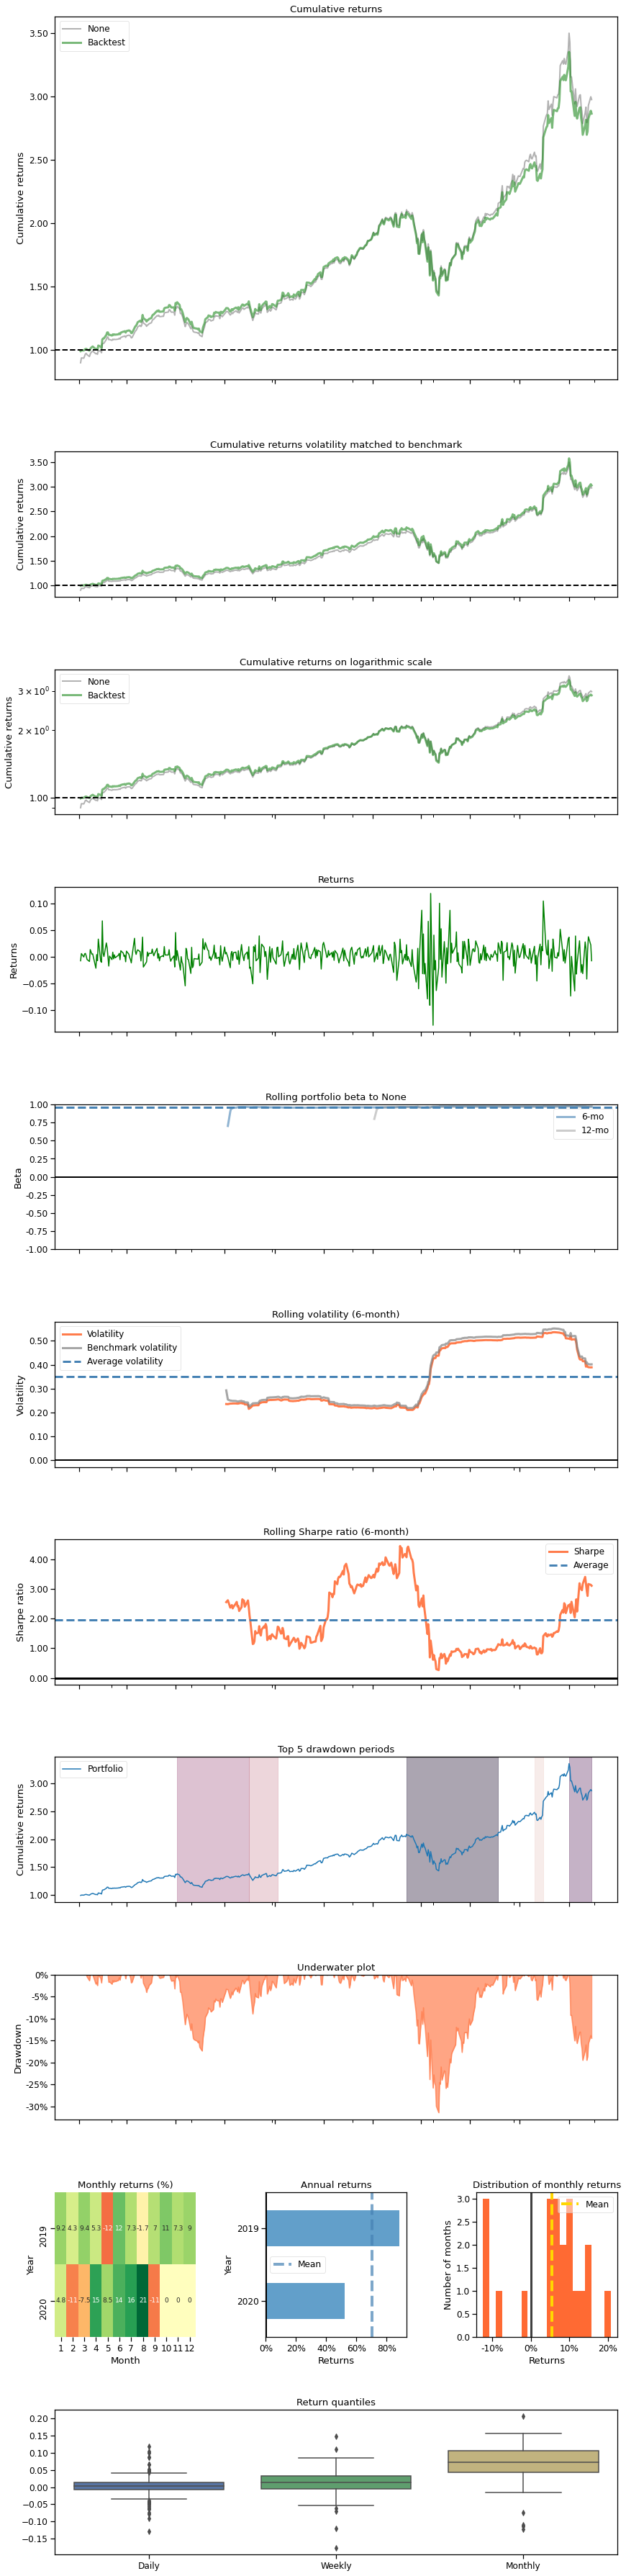

In [32]:
print("==============Compare to AAPL itself buy-and-hold===========")
%matplotlib inline
BackTestPlot(df_account_value, baseline_ticker = 'AAPL')

##References 

* Github for Baseline Source Code: https://github.com/AI4Finance-LLC/FinRL-Library/tree/master/finrl

* Baseline Colab: https://colab.research.google.com/github/AI4Finance-LLC/FinRL-Library/blob/master/FinRL_single_stock_trading.ipynb#scrollTo=0-0bsNMMTnSZ

* Project Configuration File Link: https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/master/config/config.py

* AI4Finance Project Repo: https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020

* Article and Publication: https://towardsdatascience.com/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
